In [20]:
import os, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S")

Summary run: Mon, 20 Apr 2020 10:32:46


In [22]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [23]:
pd.options.display.float_format = '{:0,.0f}'.format

In [24]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'

In [25]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

In [26]:
# Load Network Summary sheet from network_summary_detailed
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx',
                  sheetname='VMT by FC')

## Vehicle Miles Traveled (VMT)

In [27]:
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VMT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VMT']]

# Save total VMT for later use
total_vmt = df_tod.loc['Total'].values[0]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VMT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VMT
Facility Type,
arterial,"36,445,561"
highway,"40,759,864"
connector,"5,277,378"
Total,"82,482,802"


,VMT
period,
am,"19,069,957"
ev,"10,411,480"
md,"27,646,238"
ni,"5,759,113"
pm,"19,596,014"
Total,"82,482,802"


## Vehicle Hours Traveled (VHT)

In [28]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx',
                  sheetname='VHT by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VHT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VHT']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VHT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VHT
Facility Type,
arterial,"1,239,989"
highway,"940,642"
connector,"337,593"
Total,"2,518,223"


,VHT
period,
am,"587,855"
ev,"335,303"
md,"798,493"
ni,"150,830"
pm,"645,741"
Total,"2,518,223"


## Delay

In [29]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx',
                  sheetname='delay by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['Delay'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['Delay']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'Delay']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,Delay
Facility Type,
arterial,"117,569"
highway,"176,586"
Total,"294,155"


,Delay
period,
am,"91,926"
ev,"39,032"
md,"52,727"
ni,0
pm,"110,470"
Total,"294,155"


## VMT per Person

In [30]:
# Load Daysim results
trip = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_trip.tsv', sep='\t')
person = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_person.tsv', sep='\t')

In [31]:
# Load survey results
surveyh5 = h5py.File(os.path.join(relative_path,r'../inputs/base_year/observed/survey.h5'))

In [32]:
survey_trip = pd.DataFrame()
survey_person = pd.DataFrame()
for col in surveyh5['Trip'].keys():
    survey_trip[col] = surveyh5['Trip'][col][:]
    
for col in surveyh5['Person'].keys():
    survey_person[col] = surveyh5['Person'][col][:]

In [33]:
pd.options.display.float_format = '{:0,.2f}'.format


# This is average trips
# model_value = trip['trexpfac'].sum()/person['psexpfac'].sum()
# survey_value = survey_trip['trexpfac'].sum()/survey_person['psexpfac'].sum()

_df = pd.DataFrame([total_vmt/person['psexpfac'].sum()])
_df.columns = ['Average VMT per Capita']
_df



,Average VMT per Capita
0,20.32


## Trips per Person

In [34]:
model_result = (trip['trexpfac'].sum()*1.0)/person['psexpfac'].sum()
survey_result = (survey_trip['trexpfac'].sum()*1.0)/survey_person['psexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Total Trips per Capita']
_df.index = ['Model', 'Survey']
_df

,Total Trips per Capita
Model,3.96
Survey,4.54


## Average Trip Length

In [35]:
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Average Trip Length']
_df.index = ['Model','Survey']
_df

,Average Trip Length
Model,5.43
Survey,5.74


## Transit Boardings

In [36]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df

,boardings
agency_name,
King County Metro,"390,503.32"
Sound Transit,"142,774.27"
Pierce Transit,"38,002.05"
Community Transit,"30,502.13"
Kitsap Transit,"15,832.82"
Washington Ferries,"10,089.64"
Everett Transit,"6,237.91"
Region Total,"633,942.14"


## Trip Mode Share

,Model,Survey
mode,,
Walk,13.0%,12.5%
Bike,2.8%,1.3%
SOV,40.2%,40.8%
HOV2,22.6%,22.0%
HOV3+,16.3%,15.8%
Transit,2.9%,4.9%
School Bus,2.1%,2.2%


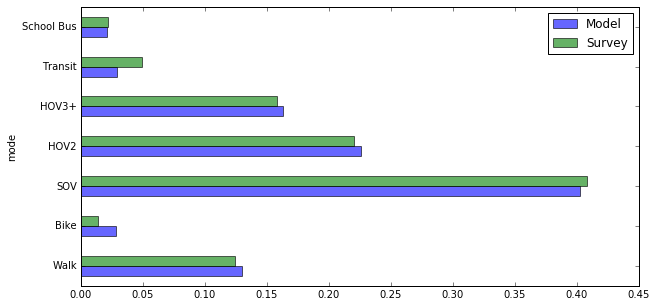

In [37]:
pd.options.display.float_format = '{:,.1%}'.format
model_df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
model_df = model_df.reset_index()
survey_df = survey_trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/survey_trip[['trexpfac']].sum()
survey_df = survey_df.reset_index()
_df = pd.merge(model_df, survey_df, on='mode', how='left')
_df.columns = ['mode','Model', 'Survey']
# _df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
# _df = _df.reset_index()
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
_df.replace({'mode':mode_dict}, inplace=True)
_df.index = _df['mode']
_df.drop('mode', axis=1, inplace=True)
dfplot = _df.drop('Other', axis=0)
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)


# Home-Based Work Trip Mode Share

In [38]:
trip['Trip Type'] = 'Not Home-Based Work'
trip.loc[(((trip['opurp']==0) & (trip['dpurp']==1)) | ((trip['opurp']==1) & (trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
hbw_trips = trip.loc[trip['Trip Type']=='Home-Based Work']
model_df_hbw = hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/hbw_trips[['trexpfac']].sum()
model_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_hbw.replace({'mode':mode_dict}, inplace=True)
model_df_hbw.columns = ['mode', 'share']
model_df_hbw

# Survey trip
survey_trip = pd.read_csv(r'C:\sc_tnc_2018\inputs\base_year\survey\_trip.tsv', delim_whitespace=True)
survey_trip.ix[(((survey_trip['opurp']==0) & (survey_trip['dpurp']==1)) | ((survey_trip['opurp']==1) & (survey_trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
survey_hbw_trips = survey_trip.loc[survey_trip['Trip Type']=='Home-Based Work']
survey_df_hbw = survey_hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_hbw_trips[['trexpfac']].sum()
survey_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_hbw.replace({'mode':mode_dict}, inplace=True)
survey_df_hbw.columns = ['mode', 'share']

survey_df_hbw.merge(model_df_hbw, on='mode', suffixes=['_model','_survey']).reset_index()

IOError: File C:\sc_tnc_2018\inputs\base_year\survey\_trip.tsv does not exist

# Other Trip Mode Share (Not Home-Based Work)

In [ ]:
nhbw_trips = trip.loc[trip['Trip Type']!='Home-Based Work']
model_df_nhbw = nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/nhbw_trips[['trexpfac']].sum()
model_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_nhbw.replace({'mode':mode_dict}, inplace=True)
model_df_nhbw.columns = ['mode', 'share']


# Survey trip
survey_nhbw_trips = trip.loc[trip['Trip Type']!='Home-Based Work']
survey_df_nhbw = survey_nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_nhbw_trips[['trexpfac']].sum()
survey_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_nhbw.replace({'mode':mode_dict}, inplace=True)
survey_df_nhbw.columns = ['mode', 'share']


survey_df_nhbw.merge(model_df_nhbw, on='mode', suffixes=['_model','_survey']).reset_index()